# Problem Set 3, due Wednesday, May 3rd, 5:30pm.

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa
program](http://en.wikipedia.org/wiki/Oportunidades), a government
social assistance program in Mexico. This program, as well as the
details of its impact, are described in the paper "[School subsidies
for the poor: evaluating the Mexican Progresa poverty
program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)",
by Paul Shultz (available on Canvas).  The data
(progresa_sample.csv.gz) is available on canvas
in files/data.

Please read the paper to familiarize yourself with
the PROGRESA program before beginning this problem set, so you have a
rough sense of where the data come from and how they were
generated. If you just proceed into the problem set without
understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic
econometric techniques that you are learning in class to measure the
impact of Progresa on secondary school enrollment rates, in particular
differences-in-differences.  Your task is to **estimate the impact of
_progresa_ subsidies on the school attendance**.  Note: this asks to
estimate a causal effect.

The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from
Canvas. The data are actual data collected to evaluate the impact of
the Progresa program.  In this file, each row corresponds to an
observation taken for a given child for a given year. There are two
years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years.  For each child-year observation, the
following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey (=1)|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre", not poor = "no pobre"|
|progresa |treatment = "basal", control = "0"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|enrolled in school in 1997 (=1) |

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Report summary statistics (mean, standard deviation, and number of missings) for all of
the demographic variables in the dataset (i.e., everything except
year, folnum, village).  Present the actual levels for 'progresa' and
'poor'.  Do these fit with the documentation above?

Present these in a single table alphabetized
by variable name. Do NOT simply expect the grader to scroll through
your output!

In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats as stats

In [405]:
# load it up
df = pd.read_csv('progresa_sample.csv')

# this changes the 'poor' column so that 'pobre' equals 1
df['poor'] = np.where(df['poor'] == "pobre", 1, 0)

# this changes the 'progresa' column so 'basal' equals 1
df['progresa'] = np.where(df['progresa'] == "basal", 1, 0)

# this produces summary stats and then reindexes alphabetically,
# keeping only count, mean, and std (for use later)
summary = df.describe().reindex(sorted(df.columns), axis=1)
summary = summary[0:3]

# this cleans up some stuff, dropping unnecessary columns
summary.drop(['year', 'folnum', 'village'], axis=1, inplace=True)

# and this collects the number of null values
summary.loc['null values'] = df.isnull().sum()

display = summary[1:].T
display


,mean,std,null values
age,11.366460,3.167744,0.0
dist_cap,147.674452,76.063134,0.0
dist_sec,2.418910,2.234109,0.0
fam_n,7.215715,2.352900,0.0
grc,3.963537,2.499063,6549.0
grc97,3.705372,2.572387,0.0
hohage,44.436717,11.620372,10.0
hohedu,2.768104,2.656106,0.0
hohsex,0.925185,0.263095,20.0
hohwag,586.985312,788.133664,0.0


### 1.2 Differences at baseline?
Now let's investigate the differences in baseline.  Are the baseline (1997) demographic characteristics **for the poor**
different in treatment and control villages?

I suggest you to use a T-Test to
determine whether there is a statistically significant difference in
the average values of each of the variables in the dataset. Focus only
on the data from 1997 for poor.

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [416]:
# start by subset!
baseline = df[df.year == 97][df.poor == 1]
baseline_treat = baseline[baseline.progresa == 1]
baseline_control = baseline[baseline.progresa == 0]

# let's drop the same coumns we did above
# we can get rid of these because producing average values for them
# won't tell us anything at all
#
# we can also drop poor (=1) and sc97/grc97 (same as sc/grc in this context)
baseline.drop(['year', 'folnum', 'village', 'poor', 'sc97', 'grc97'], axis=1, inplace=True)


baseline = baseline.dropna().groupby('progresa').mean().T.reset_index()
baseline.columns = ['variable' ,'control', 'treatment']
baseline['difference (means)'] = baseline.treatment - baseline.control


# here's the actual t-test calculations... sorry for the loop ott, i know how you hate them!
varlist = list(baseline.variable)
test = [ stats.ttest_ind(baseline_control[i], baseline_treat[i], nan_policy='omit') for i in varlist ]

# and let's make it into a dataframe
ttest = pd.DataFrame(index = varlist, data = test)

# and add a column that tells us about significance
ttest['significance'] = ttest.pvalue < 0.05

# renaming the ttest dataframe so we can combine it with the baseline info
ttest = ttest.reset_index()
ttest.columns = ['variable', 't-stat', 'pvalue', 'significance']
result = pd.merge(baseline, ttest, on='variable')

# ...and final cleanup
result.columns = ['Variable Name' ,'Average Value (Control Villages)', \
                  'Average Value (Treatment Villages)', 'Difference (Treat - Ctrl)',\
                  'T-Statistic', 'P-Value', 'Significance?']
result

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Variable Name,Average Value (Control Villages),Average Value (Treatment Villages),Difference (Treat - Ctrl),T-Statistic,P-Value,Significance?
0,sex,0.506556,0.520268,0.013713,-2.506686,1.219172e-02,True
1,indig,0.325306,0.316744,-0.008562,1.161714,2.453603e-01,False
2,dist_sec,2.400687,2.399648,-0.001039,2.100433,3.569843e-02,True
3,sc,0.815066,0.822697,0.007631,-1.668745,9.517806e-02,False
4,grc,3.733653,3.709214,-0.024439,0.400196,6.890151e-01,False
5,fam_n,7.302939,7.281032,-0.021907,0.794167,4.271039e-01,False
6,min_dist,103.098348,107.395231,4.296884,-8.206584,2.358312e-16,True
7,dist_cap,154.492095,151.801472,-2.690622,3.339081,8.415005e-04,True
8,hohedu,2.660982,2.726729,0.065747,-2.541229,1.105093e-02,True
9,hohwag,580.694452,550.207086,-30.487366,3.594588,3.253835e-04,True


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline?

*Yes, there are. See the 'Significance?' column above for entries labeled TRUE.*

* B: Why does it matter if there are differences at baseline?

*The goal of a t-test is to determine if there are differences between the means of two distributions, so that we can compare them adequately. As part of the t-test, we assume that the distributions are independent. If there are differences at baseline (i.e. if some statistical significance is shown), that means that it is harder to assert that some of the variables are independent.*

* C: What does this imply about how to measure the impact of the treatment?

*If we see statistical differences between populations at baseline, it means that the segregation method used to divide those two populations into different groups is flawed. If this is the case, this means we cannot assert that our experiment is truly random, and the outcomes may be called into question. We should probably use stratified random sampling in order to obtain a more representative sample, rather than just random. It may better address categories that "overlap" within our population.*


### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average
enrollment rate in 1997. Create a scatterplot that shows this
relationship. What do you notice?

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


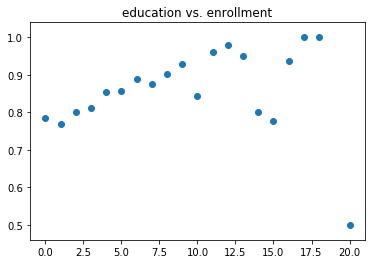

In [408]:
# using the 'baseline' variable from above (which subsets df.year==97), we can
# group by head-of-household education, and then get the mean of enrollment
ed = df[df.year == 97][df.poor == 1]
education = ed.groupby(['hohedu']).sc.mean().reset_index()

# then plot it
plt.scatter(education.hohedu, education.sc)
plt.title("education vs. enrollment")
plt.show()

*It seems that, with a couple of exceptions, there's an upward trajectory from 0 years of head-of-household education until 18 years (the max), while the level of enrollment drops dramatically (by half!) at 20 years. I would guess this has something to do with school subsidies not being as necessary if the head of household has higher education (read: gotten that oh-so-important credential). If you have more education, you most likely are at a lower risk for poverty, and thus would not have to enroll your children in this particular social program.*

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households
in treated villages**, before and after treatment.  Specifically, for
each village, calculate the average rate of enrollment of poor
households in treated villages in 1997, then compute the average rate
of enrollment of poor households in treated villages in 1998. Create
two separate histograms showing the distribution of these average
enrollments rates, one histogram for 1997 and one histogram for
1998. On each histogram, draw a vertical line that intersects the
x-axis at the average value (across all households). Does there appear
to be a difference? Is this difference statistically significant?

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


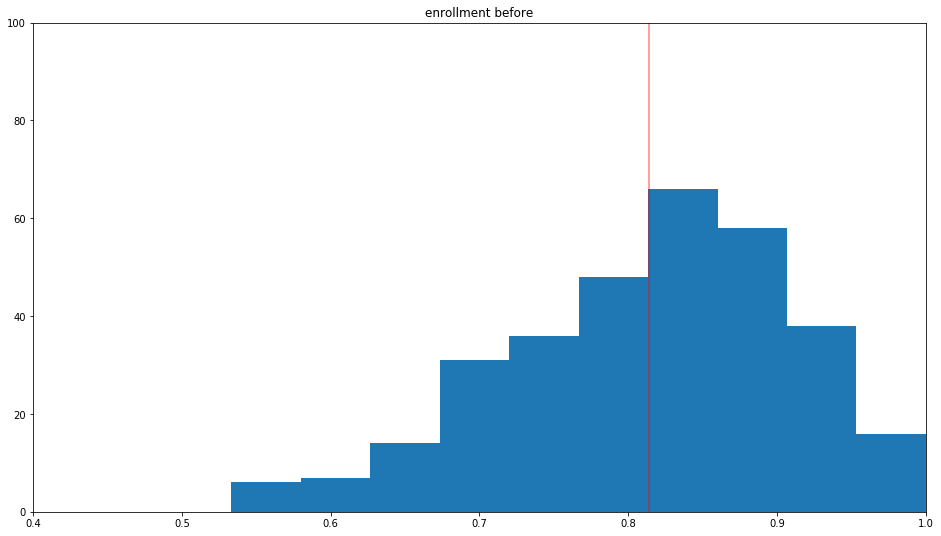

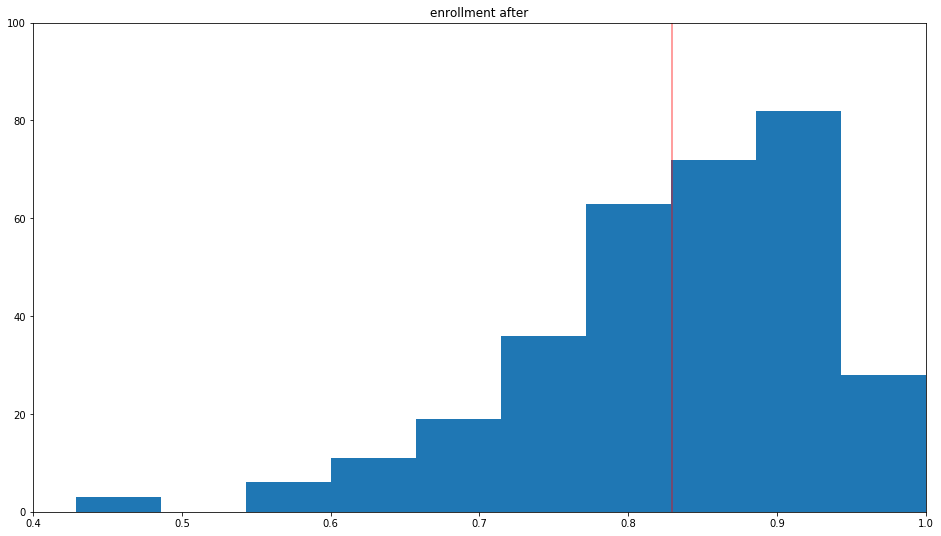

difference between means (pct): 0.0156967932034231 

t-statistic: -2.015713486515638 
p-value: 0.04424870036572115


In [417]:
# let's make a new variable really quick, and group the important information
village = df.groupby(['village', 'year', 'poor', 'progresa']).sc.mean().reset_index()

# then let's do some smart subsetting, by year
ninetyseven = village[village.year == 97]
# then by poor and treatment
ninetyseven = ninetyseven[ninetyseven.poor == 1][ninetyseven.progresa == 1]

# same thing here...
ninetyeight = village[village.year == 98]
ninetyeight = ninetyeight[ninetyeight.poor == 1][ninetyeight.progresa == 1]

# and then we plot, with the '97 data first
plt.figure(figsize=(16, 9))
# we set the axes to make sure the graphs are the same aspect ratio and scale
plt.xlim([0.4,1])
plt.ylim([0,100])
plt.hist(ninetyseven.sc)
plt.title('enrollment before')
plt.axvline(x=ninetyseven.sc.mean(), alpha=0.5, color='red')
plt.show()

# and now the '98
plt.figure(figsize=(16, 9))
plt.xlim([0.4,1])
plt.ylim([0,100])
plt.hist(ninetyeight.sc)
plt.title('enrollment after')
plt.axvline(x=ninetyeight.sc.mean(), alpha=0.5, color='red')
plt.show()

difference = ninetyeight.sc.mean() - ninetyseven.sc.mean()

# we're trying to get a t-test for the means of two independent samples, so...
ttest = stats.ttest_ind(ninetyseven.sc, ninetyeight.sc, nan_policy='omit')

print("difference between means (pct):", difference\
      , "\n\nt-statistic:", ttest[0],"\np-value:", ttest[1])

* Is there a difference? Is the difference statistically significant?

*There appears to be a difference between the average values for households across years, of a couple percent (in actuality, 1.56%). If the null hypothesis is that there is no difference in enrollment, the alternative is that there would be greater enrollment. Calculating the t-test and observing the p-values lets us know that the means are really close to but outside of the critical range (-2, 2), and that the difference between the two of these means is statistically significant.*

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on
the social and economic outcomes of individuals in Mexico. We will
focus on the impact of the program on the poor (those with
poor=='pobre'), since only the poor were eligible to receive the
PROGRESA assistance.

### 2.1 Cross-Sectional Estimator: T-test

Begin by estimating the impact of Progresa using "simple differences."
Restricting yourself to data from 1998 (after treatment), calculate
the average enrollment rate among **poor** households in the Treatment
villages and the average enrollment rate among **poor** households in
the control villages. Use a t-test to determine if this difference is
statistically significant. What do you conclude?

In [410]:
# let's reindex the dataframe a little bit, grouping by
# poor, year, and treatment

csecont = df[df.poor == 1][df.year == 98][df.progresa == 0]
csetreat = df[df.poor == 1][df.year == 98][df.progresa == 1]

# and then run a t-test, omitting NAs
csetstat = stats.ttest_ind(csetreat.sc, csecont.sc, nan_policy='omit')

print("the mean for the cse control group is",\
      csecont.sc.mean(), "\nthe mean for the cse treatment group is", csetreat.sc.mean()\
     ,"\nthe t-statistic is", csetstat.statistic, "and the p-value is", csetstat.pvalue)


the mean for the cse control group is 0.807636956730308 
the mean for the cse treatment group is 0.8464791213954308 
the t-statistic is 8.358720567418374 and the p-value is 6.636344447378102e-17


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


*After performing a cross-sectional estimator, we see that the t-statistic is outside of the critical range, and the p-value suggests significance. The difference between means is about 4%, and it appears to be a true difference (the treatment and control means are different). Practically we can conclude that Progresa appears to help poor people.*

### 2.2 Cross-Sectional Estimator: Regression

Estimate the effects of Progresa on enrollment using a regression
model, by regressing the 1998 enrollment rates **of the poor** on
treatment assignment.  Do not include any additional control
variables.
Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

Note: I recommend to use statsmodels.formula.api as this allows to use
convenient R-style formulas and provedes nice summaries of the results.

In [411]:
# Your code here
regress = df[df.year == 98][df.poor == 1]
m = smf.ols(formula = "sc~progresa", data=regress).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Wed, 02 May 2018   Prob (F-statistic):           6.64e-17
Time:                        13:22:46   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.0

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


* Based on this model, how much did Progresa increase the likelihood of a child enrolling?

*Looking at the predicted slope coefficient for 'progresa', which is interpreted as the mean change of the response variable for one unit of change in the predictor variable while holding other predictors in the model constant (what a mouthful!), it appears that progresa creates a change of about 3.9% of that unit. It appears to be a statistically significant difference as well, which is good for us, and has minimal error.*

* How does your regression estimate compare to your t-test estimate from part 2.1?

*It is approximately the same for both the regression coefficients and the t-test estimate. We take the intercept and add in the effect size for progresa, and get ~0.84, with a t-statistic of 8.359.*

* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 

*Yes, we can reject the null hypothesis that treatment effects are zero. There is some statistical significance, in terms of the p-value threshold.*

* What is the counterfactual assumption underlying this regression?

*The counterfactual assumption underlying this regression is that if a member of the target population (i.e. a poor village person from 1998) recieves treatment (i.e. a stimulus that supports going to school) that school enrollment will change, and there would be no other external factors that could cause it to change.*

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of
relevant control variables. Include, for instance, age, distance to a secondary
school, gender, education of household head, welfare index,
indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [412]:
# we can reuse the same data variable as above, but let's change model variable
n = smf.ols(formula = \
            "sc~progresa + dist_sec + grc + fam_n + indig+ min_dist\
            + dist_cap + hohedu + hohwag + hohsex + hohage + age",\
            data=regress).fit()
print(n.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     983.9
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        13:22:48   Log-Likelihood:                -7004.3
No. Observations:               27277   AIC:                         1.403e+04
Df Residuals:                   27264   BIC:                         1.414e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6594      0.016    102.204      0.0

* How do the controls affect the point estimate of treatment effect?

*We see that the addition of additional controls decreases the point estimate of the treatment effect slightly; and the t-statistic threshold increases slightly. Overall the results become more significant.*

* How do the controls affect the standard error on the treatment effect?

*The standard error decreases slightly between the two different models.*

* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

*When you add a variable to a regression model, you are controlling for it, which means you are keeping it constant. If all of the independent variables are uncorrelated, then the coefficients (the betas) of the variable should not change. However, in real life, it is often hard to isolate variables to that degree in observations (especially like the real-world situation of the Progresa study), which suggests that you have to take into account intersectional effects.*

*Simply, if you ask a different question, you get a different answer. Between questions 2.2 and 2.3 we are asking different questions--though they are quite similar, we come to different results.*

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the
difference in 1998 enrollment rates across villages. An alternative
approach would be to compute the treatment effect using a
difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate:

a) the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages

b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

c) The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?

* What is the counterfactual assumption underlying this estimate? 


In [413]:
diff = df[df.poor == 1].groupby(['year', 'progresa']).sc.mean()
diff
treat = diff[3] - diff[1]
cont = diff[2] - diff[0]
diffindiff = treat - cont
print("a (treatment difference):",treat, "\nb (control difference)  :",\
      cont,"\nc (diff-in-diff)        :", diffindiff)

a (treatment difference): 0.023782233992046597 
b (control difference)  : -0.007549046327276487 
c (diff-in-diff)        : 0.031331280319323085


* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?

*Using the tabular method, it appears that the effect size should be around 0.031. This is really close to the multi-regression and significantly lower than the cross-sectional estimator regression. Diff-in-diff is more precise, after all. :)*

* What is the counterfactual assumption underlying this estimate?

*Generally, the logic underpinning the counterfactual is that we cannot observe both treatment and control in the same population. The counterfactual assumption underlying the diff-in-diff estimator is that there are separate populations (poor people that got treatment from progresa and those that didn't) that we care about across the two years, and that if it weren't for the treatment, we would not see the results that we did.*

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment
effects of the program in a difference-in-differences
framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in
  interpreting your coefficients and standard errors, and make sure to
  specify exactly what units you are measuring and estimating.

* How do these estimates of the treatment effect compare to the
  estimates based on the simple difference?

* How do these estimates compare to the difference-in-difference
  estimates from 2.4 above? What accounts for these differences?

* What is the counterfactual assumption underlying this regression? 

In [414]:
# in order to do dif-in-diff we have to figure out a
# variable that addresses the intersection effectively.
# so lets use our good old dataframe from above
difregress = df

# and then a trick from ott in class, to resample year as T/F
difregress['time'] = (df.year > 97) + 0

# and then subset by poor
difregress = difregress[df.poor == 1]

p = smf.ols(formula = \
            "sc~progresa + progresa*time + dist_sec\
            + min_dist + dist_sec*indig + indig + fam_n + hohedu + hohsex + hohage",\
            data=difregress).fit()
print(p.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     145.4
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        13:22:53   Log-Likelihood:                -25423.
No. Observations:               58158   AIC:                         5.087e+04
Df Residuals:                   58146   BIC:                         5.098e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8565      0.012     74.

* What is your estimate of the impact of Progresa? Be very specific in
  interpreting your coefficients and standard errors, and make sure to
  specify exactly what units you are measuring and estimating.


* How do these estimates of the treatment effect compare to the
  estimates based on the simple difference?
  
*The impact here is lower than the estimates based on simple difference. This is because simple difference is 'simple'. Diff-in-diff is a decidedly more precise way to answer the question, and allows us to introduce interaction terms which produce more granular results.

* How do these estimates compare to the difference-in-difference
  estimates from 2.4 above? What accounts for these differences?
  
*In this question, we operationalize treatment and time (year of treatment) differently, looking at the intersection between the two variables. The intersectional effect is almost the same as the diff-in-diff from above, changing only because of the other control variables we decide to add. The ones I picked, for example, bring the regression coefficients to almost exactly what we got for the diff-in-diff above.*

* What is the counterfactual assumption underlying this regression? 

*The counterfactual assumption is similar to the question above--that is, the treatment and control groups would have been the same, if not for our inclusion of treatment, which produces the observed trends to the degree that we see them. In this case, we would assume normally that the factors relating to the head-of-household, the size of the family, whether or not a family is indigenous, the distance from a metro/capital center, and treatment over time would not have "done anything" to our population--our two separate populations would be the same, but for the inclusion of the 'progresa' treatment.*

### 2.6 Summary

* Based on all the analysis you have undertaken to date, do you
  believe that Progresa had a causal impact on the enrollment rates of
  poor households in Mexico?  Explain by referring to the methods and
  results above.

This is a complicated question to answer. I do believe that we can infer some kind of relationship between Progresa-as-treatment and the increase in enrollment of students in school. In that sense, there is no room to disagree: it has been effective on paper. We saw the p-values and the t-statistics above that suggest significance and results outside of the "normal" range. We also saw that, as we used more applied methods (specifically difference-in-difference), our answer for the effect size got more precise. Further, after actually reading the prospectus of the study, there are also some interesting "game theory" controls in order to prevent people from gaming the system and just taking the money. Also effective. But we have to consider other factors as well. Is what we see above enough to judge it effective on a social level, or to justify its existence as policy?

Overall, I would want to look at the control and treatment groups with a more precise lens. We saw above that there were some statistically significant differences between control and treatment groups, which means that the baseline analysis may not have been as reliable as it could have been.The equally-large effect of 'indigenous-ness' seems to suggest that maybe there's other sorts of social inequity that Progresa doesn't effectively control for.

The humanist in me believes that Progresa is a good thing. I believe that education is unquantifiably good for all people. However, the economist (or perhaps burgeoning econometricist) is concerned with the amount of money spent both by the government on this project, and the effect size. Is a 0.03 increase in enrollment good on a population level enough to justify the spending on the program?  I assume so (since the government was probably pitched this project on a possible effect size range from the onset), but I cannot say for certain.

The assumption undergirding this entire study is that direct monetary intervention is the thing that is affecting change--without Progresa, this kind of impact would not occur. What about the case that global poverty is decreasing and the standard of living is increasing, year-over-year for a long time? Perhaps we would have observed this effect over the '97-'98 period anyway, through some kind of external confounding effect (did NAFTA change financial arrangements and flows between rural poor and urban workers in Mexico--again, not sure?).

It seems that in order to judge this program effective, we have to be students of statistics, history, politics, game theory, and maybe even Spanish culture. I'm not any/all of those things, so I would defer to the numbers and simply say it is effective. To what degree, I'm not sure. 